# 4x4数独学習ノートブック（挑戦的な難易度版）

このノートブックでは、4x4の小さな数独パズルを使って、強化学習（GRPO）の基本を学びます。

## 🚀 改善版の新機能
- **強化されたSFT**: エポック数を5に増加し、データ拡張でフォーマット学習を強化
- **改良された報酬関数**: 有効な数独解に+3.0点のボーナスで、有効解率を大幅改善
- **増加した学習ステップ**: 100ステップで十分な学習時間を確保
- **挑戦的なデータセット**: Medium/Hardの難易度のみで24個のパズルを使用

## 🎯 難易度設定
- **Medium**: 空白セル8-10個（論理的思考が必要）
- **Hard**: 空白セル10-14個（複雑な推論が必要）
- **除外**: Easy難易度（空白セル6-8個）は使用しない

## 学習のポイント
- 🧩 より難しい問題で、モデルの論理的推論能力を鍛えます
- 📊 段階的な報酬システムで、複雑な問題解決を促進します  
- 💡 挑戦的な課題により、真の学習効果を測定します

## 4x4数独のルール
- 各行に1〜4の数字が1つずつ入ります
- 各列に1〜4の数字が1つずつ入ります
- 各2x2ブロックに1〜4の数字が1つずつ入ります

## 期待される学習効果
挑戦的な難易度により：
- **論理的推論能力**: 単純なパターンマッチングではなく、真の推論を学習
- **エラー耐性**: 難しい問題でも有効解を生成する能力
- **汎化性能**: 様々なパターンに対応できる柔軟性

## 1. 環境セットアップ

In [1]:
# GPU環境の確認
import torch
import os

# Torch.compileの無効化（エラー対策）
os.environ["TORCH_COMPILE_BACKEND"] = "eager"
os.environ["TORCH_DYNAMO_DISABLE"] = "1"
os.environ["UNSLOTH_DISABLE_TORCH_COMPILE"] = "1"
os.environ["TORCH_COMPILE_DISABLE"] = "1"

import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch._dynamo.config.cache_size_limit = 1
torch._dynamo.disable()

print("=== GPU環境チェック ===")
print(f"CUDA利用可能: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU名: {torch.cuda.get_device_name(0)}")
    print(f"GPUメモリ: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print("✅ GPU環境が正常に検出されました！")
else:
    print("❌ GPUが検出されません！")
    print("Google Colabの場合: ランタイム > ランタイムのタイプを変更 > T4 GPUを選択")

# Colab環境かチェック
if 'COLAB_GPU' in os.environ:
    print(f"\nGoogle Colab GPU: {os.environ['COLAB_GPU']}")
else:
    print("\nローカル環境で実行中")

=== GPU環境チェック ===
CUDA利用可能: True
GPU名: Tesla T4
GPUメモリ: 14.74 GB
✅ GPU環境が正常に検出されました！

Google Colab GPU: 1


In [2]:
%%capture
# Unslothのインストール（Google Colab用）
import os
if "COLAB_" in "".join(os.environ.keys()):
    !pip install --no-deps unsloth==2025.7.3 unsloth-zoo==2025.7.4 vllm==0.8.5.post1
else:
    !pip install unsloth==2025.7.3 unsloth-zoo==2025.7.4 vllm

In [3]:
#@title Colab追加インストール { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth==2025.7.3, unsloth-zoo==2025.7.4 vllm
else:
    !pip install --no-deps unsloth==2025.7.3 vllm==0.8.5.post1
    # Qwen3_(4B)_GRPO.ipynbと同じ設定
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth-zoo==2025.7.4
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer

    # vLLM requirements - vLLMはnumpyを再インストールするためColabを壊す
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

## 2. モデルのロード（小さめの設定）

In [4]:
# GPU環境が確認できた場合のみ実行
if not torch.cuda.is_available():
    raise RuntimeError("GPUが検出されません。上記の手順でGPUを有効にしてください。")

from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

print("モデルをロード中（初心者向けの小さめの設定）...")
max_seq_length = 512  # 4x4数独は短いので小さめに設定
lora_rank = 16        # ランクも小さめに設定

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Base",
    max_seq_length = max_seq_length,
    load_in_4bit = True,  # メモリ節約のため4bitで読み込み
    fast_inference = True,
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.5,  # GPUメモリの使用率を抑える
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = lora_rank*2,
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

print("✅ モデルのロードが完了しました！")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-24 22:43:40 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 07-24 22:43:40 [__init__.py:239] Automatically detected platform cuda.
モデルをロード中（初心者向けの小さめの設定）...
==((====))==  Unsloth 2025.7.3: Fast Qwen3 patching. Transformers: 4.53.2. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen3-4b-base-unsloth-bnb-4bit with actual GPU utilization = 49.53%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservati

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

INFO 07-24 22:44:22 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 07-24 22:44:22 [cuda.py:289] Using XFormers backend.
INFO 07-24 22:44:22 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 07-24 22:44:22 [model_runner.py:1108] Starting to load model unsloth/qwen3-4b-base-unsloth-bnb-4bit...
INFO 07-24 22:44:23 [loader.py:1187] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 07-24 22:44:23 [weight_utils.py:265] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/3.32G [00:00<?, ?B/s]

INFO 07-24 22:44:53 [weight_utils.py:281] Time spent downloading weights for unsloth/qwen3-4b-base-unsloth-bnb-4bit: 29.632582 seconds
INFO 07-24 22:44:53 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 07-24 22:45:02 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 07-24 22:45:02 [model_runner.py:1140] Model loading took 3.1824 GiB and 39.494968 seconds
INFO 07-24 22:45:12 [worker.py:287] Memory profiling takes 9.40 seconds
INFO 07-24 22:45:12 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.30GiB
INFO 07-24 22:45:12 [worker.py:287] model weights take 3.18GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 1.05GiB; the rest of the memory reserved for KV Cache is 3.05GiB.
INFO 07-24 22:45:13 [executor_base.py:112] # cuda blocks: 1386, # CPU blocks: 0
INFO 07-24 22:45:13 [executor_base.py:117] Maximum concurrency for 512 tokens per request: 43.31x
INFO 07-24 22:45:13 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-

Capturing CUDA graph shapes:   0%|          | 0/27 [00:00<?, ?it/s]

INFO 07-24 22:46:08 [model_runner.py:1592] Graph capturing finished in 56 secs, took 0.67 GiB
INFO 07-24 22:46:08 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 66.05 seconds
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['pre_feedforward_layernorm', 'post_feedforward_layernorm']


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2025.7.3 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


✅ モデルのロードが完了しました！


## 3. チャットテンプレートの設定

In [5]:
# 解答フォーマットのタグを定義
reasoning_start = "<reasoning>"
reasoning_end   = "</reasoning>"
solution_start  = "<answer>"
solution_end    = "</answer>"

# 4x4数独用のシステムプロンプト
system_prompt = f"""あなたは4x4数独パズルを解く専門家です。
4x4数独のルール：
- 各行に1〜4の数字が1つずつ入ります
- 各列に1〜4の数字が1つずつ入ります
- 各2x2ブロックに1〜4の数字が1つずつ入ります

出力フォーマット：
1. 思考過程は{reasoning_start}と{reasoning_end}の間に記述してください。
2. 最終的な解答は{solution_start}と{solution_end}の間に16文字の数字列として記述してください。
   （左上から右へ、上から下へ順番に記述）

例：
{reasoning_start}
左上の2x2ブロックを見ると、1と3があるので、残りは2と4です。
1行目には既に1があるので、1行2列目は2または4です。
{reasoning_end}
{solution_start}
1234341242131342
{solution_end}"""

# チャットテンプレートを設定
chat_template = """{% if messages[0]['role'] == 'system' %}{{ messages[0]['content'] + eos_token }}{% set loop_messages = messages[1:] %}{% else %}{{ '{system_prompt}' + eos_token }}{% set loop_messages = messages %}{% endif %}{% for message in loop_messages %}{% if message['role'] == 'user' %}{{ message['content'] }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '{reasoning_start}' }}{% endif %}"""

chat_template = chat_template.replace("'{system_prompt}'", f"'{system_prompt}'").replace("'{reasoning_start}'", f"'{reasoning_start}'")
tokenizer.chat_template = chat_template

print("✅ 4x4数独用のチャットテンプレートを設定しました")

✅ 4x4数独用のチャットテンプレートを設定しました


## 4. 4x4数独データセットの準備

In [6]:
!pip install japanize-matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 57.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=e62aa4156dbca7c459cc2a5ec9bfa79c758600beae423440a08acff055dd9df8
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [ ]:
import re
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')  # バックエンドを設定
import japanize_matplotlib
from datetime import datetime
from pathlib import Path
from collections import deque
from IPython.display import display, clear_output
import json

# 正規表現パターンを定義（改善版）
# reasoningタグの検出を改善
reasoning_pattern = re.compile(
    rf"{re.escape(reasoning_start)}\s*(.+?)\s*{re.escape(reasoning_end)}",
    flags=re.MULTILINE | re.DOTALL
)

answer_pattern = re.compile(
    rf"{re.escape(solution_start)}\s*(.+?)\s*{re.escape(solution_end)}",
    flags=re.MULTILINE | re.DOTALL
)

def extract_answer(response):
    """応答から解答を抽出（改善版）"""
    match = answer_pattern.search(response)
    if match:
        answer_text = match.group(1).strip()
        # 数字のみを抽出（改行やスペースを除去）
        digits = ''.join(c for c in answer_text if c.isdigit())
        return digits if len(digits) == 16 else None
    return None

def has_reasoning_tags(response):
    """reasoningタグの存在をチェック（改善版）"""
    return reasoning_pattern.search(response) is not None

def has_answer_tags(response):
    """answerタグの存在をチェック（改善版）"""
    return answer_pattern.search(response) is not None

def is_valid_4x4_sudoku(sudoku_str):
    """4x4数独として有効かチェック"""
    if not sudoku_str or len(sudoku_str) != 16 or not sudoku_str.isdigit():
        return False

    board = np.array([int(c) for c in sudoku_str]).reshape(4, 4)

    # 各行のチェック
    for row in board:
        if len(set(row)) != 4 or not all(1 <= x <= 4 for x in row):
            return False

    # 各列のチェック
    for col in board.T:
        if len(set(col)) != 4 or not all(1 <= x <= 4 for x in col):
            return False

    # 各2x2ボックスのチェック
    for box_row in range(0, 4, 2):
        for box_col in range(0, 4, 2):
            box = board[box_row:box_row+2, box_col:box_col+2].flatten()
            if len(set(box)) != 4 or not all(1 <= x <= 4 for x in box):
                return False

    return True

# グローバル変数（ログ記録用）
global_step = 0
reward_history = []
accuracy_history = []
valid_solution_history = []
format_compliance_history = []

# ログ保存用の設定
log_dir = Path("./logs")
log_dir.mkdir(exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = log_dir / f"sudoku4x4_training_{timestamp}.jsonl"
detailed_log_filename = log_dir / f"sudoku4x4_training_{timestamp}_detailed.jsonl"

print(f"📁 ログファイル: {log_filename}")
print(f"📁 詳細ログファイル: {detailed_log_filename}")

def save_step_log(step_data):
    """ステップごとの詳細ログを保存"""
    with open(detailed_log_filename, 'a', encoding='utf-8') as f:
        json.dump(step_data, f, ensure_ascii=False)
        f.write('\n')

def update_visualization():
    """5ステップごとにグラフを更新"""
    # 出力をクリア
    clear_output(wait=True)

    # 新しい図を作成
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('4x4数独 GRPO学習の進捗', fontsize=16)

    steps = list(range(1, len(reward_history) + 1))

    # 1. 平均報酬の推移
    ax1 = axes[0, 0]
    if len(reward_history) > 0:
        # 移動平均を計算（window=5）
        window_size = min(5, len(reward_history))
        moving_avg = []
        for i in range(len(reward_history)):
            start_idx = max(0, i - window_size + 1)
            moving_avg.append(np.mean(reward_history[start_idx:i+1]))

        ax1.plot(steps, reward_history, 'b-', alpha=0.3, label='各ステップ')
        ax1.plot(steps, moving_avg, 'b-', linewidth=2, label='移動平均')
        ax1.axhline(y=10.0, color='g', linestyle='--', label='最大スコア(10.0)')
        ax1.set_xlabel('ステップ')
        ax1.set_ylabel('報酬')
        ax1.set_title('報酬の推移')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(-5, 10.5)

    # 2. 正解率の推移
    ax2 = axes[0, 1]
    if len(accuracy_history) > 0:
        # 累積正解率を計算
        cumulative_accuracy = []
        for i in range(1, len(accuracy_history) + 1):
            cumulative_accuracy.append(sum(accuracy_history[:i]) / i * 100)

        ax2.plot(steps, cumulative_accuracy, 'g-', linewidth=2, label='累積正解率')
        ax2.set_xlabel('ステップ')
        ax2.set_ylabel('正解率 (%)')
        ax2.set_title('累積正解率の推移')
        ax2.set_ylim(0, 105)
        ax2.grid(True, alpha=0.3)
        ax2.legend()

    # 3. 有効解率の推移
    ax3 = axes[1, 0]
    if len(valid_solution_history) > 0:
        # 累積有効解率を計算
        cumulative_valid = []
        for i in range(1, len(valid_solution_history) + 1):
            cumulative_valid.append(sum(valid_solution_history[:i]) / i * 100)

        ax3.plot(steps, cumulative_valid, 'orange', linewidth=2, label='累積有効解率')
        ax3.set_xlabel('ステップ')
        ax3.set_ylabel('有効解率 (%)')
        ax3.set_title('有効な4x4数独解の生成率')
        ax3.set_ylim(0, 105)
        ax3.grid(True, alpha=0.3)
        ax3.legend()

    # 4. フォーマット遵守率
    ax4 = axes[1, 1]
    if len(format_compliance_history) > 0:
        # 累積フォーマット遵守率を計算
        cumulative_format = []
        for i in range(1, len(format_compliance_history) + 1):
            cumulative_format.append(sum(format_compliance_history[:i]) / i * 100)

        ax4.plot(steps, cumulative_format, 'purple', linewidth=2, label='累積フォーマット遵守率')
        ax4.set_xlabel('ステップ')
        ax4.set_ylabel('フォーマット遵守率 (%)')
        ax4.set_title('正しいフォーマットでの出力率')
        ax4.set_ylim(0, 105)
        ax4.grid(True, alpha=0.3)
        ax4.legend()

    plt.tight_layout()

    # Jupyter Notebookで表示
    display(fig)
    plt.close(fig)

def beginner_friendly_reward(prompts, completions, answer, **kwargs):
    """初心者向けの段階的報酬関数（v2 - 有効解重視版）"""
    global global_step, reward_history, accuracy_history, valid_solution_history, format_compliance_history

    responses = [c[0]["content"] for c in completions]
    extracted_answers = [extract_answer(r) for r in responses]
    scores = []

    batch_correct = 0
    batch_valid = 0
    batch_format_ok = 0

    for idx, (prompt, response, extracted, true_answer) in enumerate(
        zip(prompts, responses, extracted_answers, answer)
    ):
        score = 0.0

        # プロンプトから質問を抽出
        question = ""
        puzzle_str = ""
        if isinstance(prompt, list):
            for msg in prompt:
                if isinstance(msg, dict) and msg.get('role') == 'user':
                    question = msg.get('content', '')
                    # パズル文字列を抽出（改行を除去）
                    if ":" in question:
                        puzzle_str = question.split(":")[-1].strip()
                        puzzle_str = puzzle_str.replace("\\n", "").strip()
                    break
        else:
            question = str(prompt)

        # フォーマットチェック（改善版）
        has_reasoning = has_reasoning_tags(response)
        has_answer = has_answer_tags(response)

        # ステップ1: 基本的なフォーマットチェック（重み付けを調整）
        if has_answer:  # answerタグは必須
            score += 1.0  # 1.0点に増加
            if has_reasoning:  # reasoningタグもあればボーナス
                score += 0.5
                batch_format_ok += 1
        else:
            # answerタグがない場合は大きなペナルティ
            score -= 3.0

        # ステップ2: 解答抽出成功
        if extracted is not None:
            if len(extracted) == 16:
                score += 1.0  # 16文字抽出できた（1.0点に増加）

                # ステップ3: 数字の範囲チェック
                if all(c in '1234' for c in extracted):
                    score += 1.0  # 有効な数字範囲（1.0点に増加）

                    # ステップ4: 有効解チェック（大幅強化）
                    is_valid = is_valid_4x4_sudoku(extracted)
                    if is_valid:
                        score += 3.0  # 有効解に大きなボーナス（3.0点）
                        batch_valid += 1

                    # ステップ5: 正解チェック
                    if extracted == true_answer:
                        score += 3.0  # 完全正解で追加3.0点
                        batch_correct += 1
                    else:
                        # 部分的な正解（最大1.5点）
                        matches = sum(1 for i in range(16)
                                    if extracted[i] == true_answer[i])
                        partial_score = (matches / 16) * 1.5
                        score += partial_score
                else:
                    # 1-4以外の数字が含まれている場合
                    score -= 1.0
            else:
                # 16文字でない場合
                score -= 2.0
        else:
            # 抽出失敗の場合
            score -= 2.0

        # スコアの範囲を制限（-5.0 〜 10.0）
        score = max(-5.0, min(10.0, score))
        scores.append(score)

        # ログに記録
        global_step += 1
        reward_history.append(score)
        accuracy_history.append(1 if extracted == true_answer else 0)
        valid_solution_history.append(1 if extracted and is_valid_4x4_sudoku(extracted) else 0)
        format_compliance_history.append(1 if has_reasoning and has_answer else 0)

        # 各ステップの詳細をログに保存
        step_log = {
            'step': global_step,
            'timestamp': datetime.now().isoformat(),
            'question': question,
            'puzzle': puzzle_str,
            'ai_response': response,
            'extracted_answer': extracted if extracted else None,
            'correct_answer': true_answer,
            'is_correct': extracted == true_answer if extracted else False,
            'is_valid_sudoku': is_valid_4x4_sudoku(extracted) if extracted else False,
            'reward': float(score),
            'has_reasoning': has_reasoning,
            'has_answer': has_answer,
            'response_length': len(response),
            'matches': sum(1 for i in range(16) if extracted and i < len(extracted) and extracted[i] == true_answer[i]) if extracted else 0,
            'reward_breakdown': {
                'format_score': 1.5 if has_reasoning and has_answer else (1.0 if has_answer else -3.0),
                'extraction_score': 1.0 if extracted and len(extracted) == 16 else (-2.0 if not extracted else -2.0),
                'validity_score': 1.0 if extracted and all(c in '1234' for c in str(extracted)) else 0,
                'valid_solution_bonus': 3.0 if extracted and is_valid_4x4_sudoku(extracted) else 0,
                'correct_answer_bonus': 3.0 if extracted == true_answer else 0,
                'partial_match_score': (matches / 16) * 1.5 if 'matches' in locals() and extracted != true_answer else 0
            }
        }

        # 詳細ログを保存
        save_step_log(step_log)

        # 5ステップごとに進捗表示と可視化更新
        if global_step % 5 == 0:
            recent_rewards = reward_history[-5:]
            recent_accuracy = accuracy_history[-5:]
            recent_valid = valid_solution_history[-5:]
            recent_format = format_compliance_history[-5:]

            print(f"\n{'='*60}")
            print(f"📊 ステップ {global_step} - 4x4数独学習進捗")
            print(f"{'='*60}")
            print(f"直近5ステップの統計:")
            print(f"  平均報酬: {np.mean(recent_rewards):.2f} / 10.0")
            print(f"  正解率: {sum(recent_accuracy)}/{len(recent_accuracy)} ({sum(recent_accuracy)*20}%)")
            print(f"  有効解率: {sum(recent_valid)}/{len(recent_valid)} ({sum(recent_valid)*20}%)")
            print(f"  フォーマット遵守率: {sum(recent_format)}/{len(recent_format)} ({sum(recent_format)*20}%)")

            # 全体の統計も表示
            print(f"\n全体統計 (総ステップ数: {global_step}):")
            print(f"  累積正解率: {sum(accuracy_history)}/{len(accuracy_history)} ({sum(accuracy_history)/len(accuracy_history)*100:.1f}%)")
            print(f"  累積有効解率: {sum(valid_solution_history)}/{len(valid_solution_history)} ({sum(valid_solution_history)/len(valid_solution_history)*100:.1f}%)")

            # 最新の生成例を表示
            if idx < len(responses):
                print(f"\n最新の生成例:")
                print(f"  パズル: {puzzle_str[:16] if puzzle_str else 'N/A'}")
                print(f"  抽出答案: {extracted if extracted else '抽出失敗'}")
                print(f"  正解: {true_answer}")
                if extracted and len(extracted) == 16:
                    matches = sum(1 for i in range(16) if extracted[i] == true_answer[i])
                    print(f"  一致率: {matches}/16 ({matches*6.25:.1f}%)")
                print(f"  報酬: {score:.2f}")
                print(f"  タグ: reasoning={'✅' if has_reasoning else '❌'}, answer={'✅' if has_answer else '❌'}")
                if extracted and is_valid_4x4_sudoku(extracted):
                    print(f"  有効解: ✅")

            # グラフを更新
            update_visualization()

            # 統計情報を保存
            stats_log = {
                'step': global_step,
                'timestamp': datetime.now().isoformat(),
                'type': 'statistics',
                'recent_5_steps': {
                    'avg_reward': float(np.mean(recent_rewards)),
                    'accuracy': sum(recent_accuracy) / len(recent_accuracy),
                    'valid_rate': sum(recent_valid) / len(recent_valid),
                    'format_compliance': sum(recent_format) / len(recent_format)
                },
                'cumulative': {
                    'total_steps': global_step,
                    'avg_reward': float(np.mean(reward_history)),
                    'accuracy': sum(accuracy_history) / len(accuracy_history),
                    'valid_rate': sum(valid_solution_history) / len(valid_solution_history),
                    'format_compliance': sum(format_compliance_history) / len(format_compliance_history)
                }
            }

            with open(log_filename, 'a', encoding='utf-8') as f:
                json.dump(stats_log, f, ensure_ascii=False)
                f.write('\n')

            print(f"{'='*60}")

    return scores

print("✅ 初心者向け報酬関数を定義しました（v2 - 有効解重視版）")
print("📊 改善された報酬システム:")
print("  1. answerタグあり: +1.0点（増加）")
print("  2. reasoningタグもあり: +0.5点（合計+1.5点）")
print("  3. 16文字抽出成功: +1.0点（増加）")
print("  4. 数字範囲正しい: +1.0点（増加）")
print("  5. 有効な数独解: +3.0点（大幅増加）")
print("  6. 完全正解: +3.0点")
print("  7. 部分一致: 最大+1.5点")
print("ペナルティ:")
print("  - answerタグなし: -3点（増加）")
print("  - 抽出失敗: -2点")
print("  - 16文字でない: -2点")
print("  - 無効な数字: -1点")
print("最大スコア: 10点、最小スコア: -5点")
print("\n📈 5ステップごとにグラフが更新されます")
print(f"💾 全ステップの詳細ログが保存されます: {detailed_log_filename}")

In [14]:
# 解答フォーマットのタグを定義
reasoning_start = "<reasoning>"
reasoning_end   = "</reasoning>"
solution_start  = "<answer>"
solution_end    = "</answer>"

# 4x4数独用のシステムプロンプト
system_prompt = f"""あなたは4x4数独パズルを解く専門家です。
4x4数独のルール：
- 各行に1〜4の数字が1つずつ入ります
- 各列に1〜4の数字が1つずつ入ります
- 各2x2ブロックに1〜4の数字が1つずつ入ります

出力フォーマット：
1. 思考過程は{reasoning_start}と{reasoning_end}の間に記述してください。
2. 最終的な解答は{solution_start}と{solution_end}の間に16文字の数字列として記述してください。
   （左上から右へ、上から下へ順番に記述）

例：
{reasoning_start}
左上の2x2ブロックを見ると、1と3があるので、残りは2と4です。
1行目には既に1があるので、1行2列目は2または4です。
{reasoning_end}
{solution_start}
1234341242131342
{solution_end}"""

# チャットテンプレートを設定
chat_template = """{% if messages[0]['role'] == 'system' %}{{ messages[0]['content'] + eos_token }}{% set loop_messages = messages[1:] %}{% else %}{{ '{system_prompt}' + eos_token }}{% set loop_messages = messages %}{% endif %}{% for message in loop_messages %}{% if message['role'] == 'user' %}{{ message['content'] }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token }}{% endif %}{% endfor %}{% if add_generation_prompt %}{{ '{reasoning_start}' }}{% endif %}"""

chat_template = chat_template.replace("'{system_prompt}'", f"'{system_prompt}'").replace("'{reasoning_start}'", f"'{reasoning_start}'")
tokenizer.chat_template = chat_template

print("✅ 4x4数独用のチャットテンプレートを設定しました")

✅ 4x4数独用のチャットテンプレートを設定しました


## 5. 初心者向け報酬関数の定義

## 6. 事前学習（SFT）- モデルにフォーマットを教える

In [ ]:
import json
import numpy as np
from pathlib import Path
from datasets import Dataset
import pandas as pd

# Google Colab環境用のパス設定
if 'COLAB_GPU' in os.environ:
    data_path = Path("/content/dataset/sudoku4x4")
else:
    data_path = Path("./dataset/sudoku4x4")

# データセット読み込み（mediumとhardのみ使用）
all_data = []
for difficulty in ['medium', 'hard']:  # 難易度を上げてmediumとhardのみ使用
    file_path = data_path / f"sudoku4x4_{difficulty}.jsonl"
    if file_path.exists():
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                data = json.loads(line.strip())
                all_data.append(data)
        print(f"{difficulty}: {sum(1 for d in all_data if d['difficulty'] == difficulty)}個")
    else:
        print(f"⚠️ ファイルが見つかりません: {file_path}")

print(f"\n総データ数: {len(all_data)}個")

# データが無い場合は挑戦的なパズルを生成
if len(all_data) == 0:
    print("\n📝 挑戦的なデータセットを生成します...")
    # より難しい4x4数独パズルを生成
    sample_puzzles = [
        # Medium (8-10 empty cells) - より論理的思考が必要
        {"puzzle": "0000230000100030", "solution": "1423231442132314", "difficulty": "medium"},
        {"puzzle": "0200130000430000", "solution": "4213132442132314", "difficulty": "medium"},
        {"puzzle": "0000310000000030", "solution": "4213132442132314", "difficulty": "medium"},
        {"puzzle": "4102030100000423", "solution": "4132234132141423", "difficulty": "medium"},
        {"puzzle": "0100300000030024", "solution": "2134341231432124", "difficulty": "medium"},
        {"puzzle": "1200430000000010", "solution": "1234432112342143", "difficulty": "medium"},
        {"puzzle": "0000230000100030", "solution": "1423231442132314", "difficulty": "medium"},
        {"puzzle": "0000300000300021", "solution": "4132231432142134", "difficulty": "medium"},
        
        # Hard (10-14 empty cells) - 複雑な推論が必要
        {"puzzle": "0000100000200000", "solution": "3421142334122413", "difficulty": "hard"},
        {"puzzle": "1000420000000000", "solution": "1324421331422314", "difficulty": "hard"},
        {"puzzle": "0000030000300010", "solution": "1423234141322413", "difficulty": "hard"},
        {"puzzle": "0304042040003000", "solution": "2314142341323241", "difficulty": "hard"},
        {"puzzle": "0002001002401003", "solution": "4132231432411423", "difficulty": "hard"},
        {"puzzle": "0340410300020000", "solution": "2341412314323214", "difficulty": "hard"},
        {"puzzle": "0342000100140000", "solution": "1342243132144123", "difficulty": "hard"},
        {"puzzle": "0004400001402030", "solution": "1324421331422431", "difficulty": "hard"},
        {"puzzle": "0002001000204201", "solution": "1342241331244231", "difficulty": "hard"},
        {"puzzle": "0000000000410000", "solution": "2134341241324213", "difficulty": "hard"},
        {"puzzle": "0000210000000000", "solution": "4312213441323214", "difficulty": "hard"},
        {"puzzle": "0000200000300004", "solution": "4123231432142314", "difficulty": "hard"},
        
        # Very Hard (12-14 empty cells) - 最高難度
        {"puzzle": "0000000000000024", "solution": "4132231432142314", "difficulty": "hard"},
        {"puzzle": "4000000000000004", "solution": "4123231432142314", "difficulty": "hard"},
        {"puzzle": "0200000000040002", "solution": "4213132442132314", "difficulty": "hard"},
        {"puzzle": "0000040000020000", "solution": "3124241331422413", "difficulty": "hard"},
    ]
    
    for i, p in enumerate(sample_puzzles):
        all_data.append({
            "id": f"sample_{i}",
            "difficulty": p["difficulty"],
            "puzzle": p["puzzle"],
            "solution": p["solution"],
            "problem": f"次の4x4数独パズルを解いてください。0は空白を表します:\\n{p['puzzle']}",
            "empty_cells": p['puzzle'].count('0')
        })

print(f"\n最終データ数: {len(all_data)}個")

# 空白セル数の統計を表示
if all_data:
    empty_cells_list = [d.get('empty_cells', d['puzzle'].count('0')) for d in all_data]
    print(f"\n空白セル数の統計:")
    print(f"  最小: {min(empty_cells_list)}個")
    print(f"  最大: {max(empty_cells_list)}個")
    print(f"  平均: {np.mean(empty_cells_list):.1f}個")

# データセットのフォーマット
def format_dataset_for_grpo(item):
    """GRPO用にデータセットをフォーマット"""
    question = item['problem']
    solution = item['solution']
    empty_cells = item.get('empty_cells', item['puzzle'].count('0'))

    # 空白セル数に応じた思考過程
    if empty_cells <= 8:
        thoughts = "空白が8個以下です。各行・列・ブロックの制約を確認しながら、論理的に数字を配置していきます。"
    elif empty_cells <= 10:
        thoughts = "空白が10個程度あります。複数の制約を同時に考慮し、候補を絞り込みながら解いていきます。"
    elif empty_cells <= 12:
        thoughts = "空白が12個もあり難しいパズルです。可能な数字の候補を記録しながら、段階的に解を導きます。"
    else:
        thoughts = "非常に難しいパズルです。全ての制約を慎重に確認し、試行錯誤しながら正しい配置を見つけていきます。"

    # フォーマットされた応答
    final_response = (
        f"{reasoning_start}\\n{thoughts}\\n{reasoning_end}\\n"
        f"{solution_start}\\n{solution}\\n{solution_end}"
    )

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
        {"role": "assistant", "content": final_response}
    ]

    return {
        "messages": messages,
        "prompt": messages[:-1],  # システム＋ユーザーメッセージ
        "answer": solution,       # 正解の16文字
        "puzzle": item['puzzle'],
        "empty_cells": empty_cells
    }

# すべてのデータをフォーマット
formatted_data = [format_dataset_for_grpo(item) for item in all_data]

# GRPO用データセット
grpo_data = [{
    "prompt": item["prompt"],
    "answer": item["answer"],
    "puzzle": item["puzzle"],
    "empty_cells": item["empty_cells"]
} for item in formatted_data]

dataset = Dataset.from_list(grpo_data)
train_dataset = dataset

print(f"\\nGRPOトレーニングデータセット: {len(train_dataset)}個")
print(f"データセットのキー: {list(train_dataset[0].keys())}")

# サンプル表示
if len(train_dataset) > 0:
    sample = train_dataset[0]
    print(f"\\nサンプルパズル: {sample['puzzle']} (空白{sample['empty_cells']}個)")
    print(f"正解: {sample['answer']}")
    
    # 難易度分布を表示
    easy_count = sum(1 for item in all_data if item['difficulty'] == 'easy')
    medium_count = sum(1 for item in all_data if item['difficulty'] == 'medium')
    hard_count = sum(1 for item in all_data if item['difficulty'] == 'hard')
    
    print(f"\\n難易度分布:")
    print(f"  Easy: {easy_count}個")
    print(f"  Medium: {medium_count}個")
    print(f"  Hard: {hard_count}個")
    
    print(f"\\n🎯 挑戦的なデータセット:")
    print(f"  - 空白セル数: 8-14個（全16セル中）")
    print(f"  - 論理的推論が必要な難易度")
    print(f"  - 段階的な解法が求められるパズル")

In [ ]:
# SFT用データセットの準備（拡張版）
sft_data = []

# より多くのトレーニング例を生成
example_responses = [
    "左上の2x2ブロックを見ると、数字を配置していきます。",
    "各行、列、2x2ブロックに1-4が1つずつ入るように解きます。", 
    "空いているセルを順番に埋めていきます。",
    "数独のルールに従って、論理的に解を導きます。",
    "まず既存の数字から、可能な配置を推測します。"
]

# データを増やす（各データを複数回、異なる思考で使用）
for i, item in enumerate(formatted_data[:20]):
    # 元のデータを追加
    sft_data.append(item)
    
    # バリエーションを追加（同じ問題に異なる思考過程）
    for j in range(2):  # 各問題に対して2つのバリエーション
        variation = item.copy()
        thought_idx = (i + j) % len(example_responses)
        
        # 異なる思考過程で同じ解答
        new_response = (
            f"{reasoning_start}\n{example_responses[thought_idx]}\n{reasoning_end}\n"
            f"{solution_start}\n{item['answer']}\n{solution_end}"
        )
        
        variation['messages'] = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": item['messages'][1]['content']},
            {"role": "assistant", "content": new_response}
        ]
        sft_data.append(variation)

print(f"拡張されたSFTデータ: {len(sft_data)}個")

# DataFrameに変換
sft_df = pd.DataFrame(sft_data)
sft_df["text"] = tokenizer.apply_chat_template(sft_df["messages"].values.tolist(), tokenize=False)

# HuggingFace Dataset形式に変換
from datasets import Dataset
pre_train_dataset = Dataset.from_pandas(sft_df)

print(f"事前学習データセット: {len(pre_train_dataset)}個")

# SFTトレーニング（改善版）
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = pre_train_dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 2,  # バッチサイズを増加
        gradient_accumulation_steps = 2,   # 勾配蓄積を追加
        warmup_steps = 10,
        num_train_epochs = 5,  # エポック数を5に増加
        learning_rate = 1e-4,  # 学習率を少し下げる
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",  # コサインスケジューラーに変更
        seed = 3407,
        report_to = "none",
        output_dir = "./sft_output_4x4_improved",
    ),
)

print("\n🎓 強化されたフォーマット学習を開始...")
print(f"📚 データ数: {len(pre_train_dataset)}個")
print(f"🔄 エポック数: 5")
print(f"📈 総ステップ数（予想）: {len(pre_train_dataset) // 2 * 5}ステップ")

train_result = trainer.train()

print(f"\n✅ 強化されたフォーマット学習が完了しました")
print(f"総ステップ数: {train_result.global_step}")
print(f"最終損失: {train_result.training_loss:.4f}")
print(f"平均損失: {train_result.metrics['train_runtime'] / train_result.global_step:.4f}秒/ステップ")

## 7. GRPO強化学習の設定

In [ ]:
# GRPO設定
from vllm import SamplingParams
from trl import GRPOConfig

# プロンプトの最大長を計算
tokenized = train_dataset.map(
    lambda x: {"tokens": tokenizer.apply_chat_template(x["prompt"], add_generation_prompt=True, tokenize=True)},
    batched=True,
)
tokenized = tokenized.map(lambda x: {"L": len(x["tokens"])})
maximum_length = int(np.quantile(tokenized["L"], 0.9))

max_prompt_length = maximum_length + 1
max_completion_length = max_seq_length - max_prompt_length

print(f"最大プロンプト長: {max_prompt_length}")
print(f"最大生成長: {max_completion_length}")

# vLLMサンプリングパラメータ（改善版）
sampling_params = SamplingParams(
    min_p = 0.1,
    top_p = 0.9,      # より焦点を絞った生成
    top_k = 40,       # top_kを少し下げる
    seed = 3407,
    temperature = 0.7,  # さらに低めの温度で安定性重視
    max_tokens = max_completion_length,
    stop = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

# GRPO設定（改善版）
training_args = GRPOConfig(
    vllm_sampling_params = sampling_params,
    temperature = 0.7,
    learning_rate = 1e-6,  # さらに低めの学習率で安定性重視
    weight_decay = 0.05,   # 正則化を強化
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",  # コサインスケジューラー
    optim = "adamw_8bit",
    logging_steps = 1,
    per_device_train_batch_size = 2,    # バッチサイズを増加
    gradient_accumulation_steps = 2,     # 勾配蓄積を追加
    num_generations = 4,  # 生成数を増やして多様性確保
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    max_steps = 100,  # ステップ数を100に増加
    save_steps = 50,
    report_to = "none",
    output_dir = "outputs_4x4_improved",
)

print("✅ GRPO設定を完了しました（改善版）")
print("📊 改善点:")
print("  - SFTエポック数: 5回（フォーマット学習強化）")
print("  - 学習ステップ数: 100ステップ（倍増）")
print("  - 温度: 0.7（より安定した生成）")
print("  - 生成数: 4（多様性向上）")
print("  - 報酬関数: 有効解を重視（+3.0点）")

## 8. GRPO学習の実行

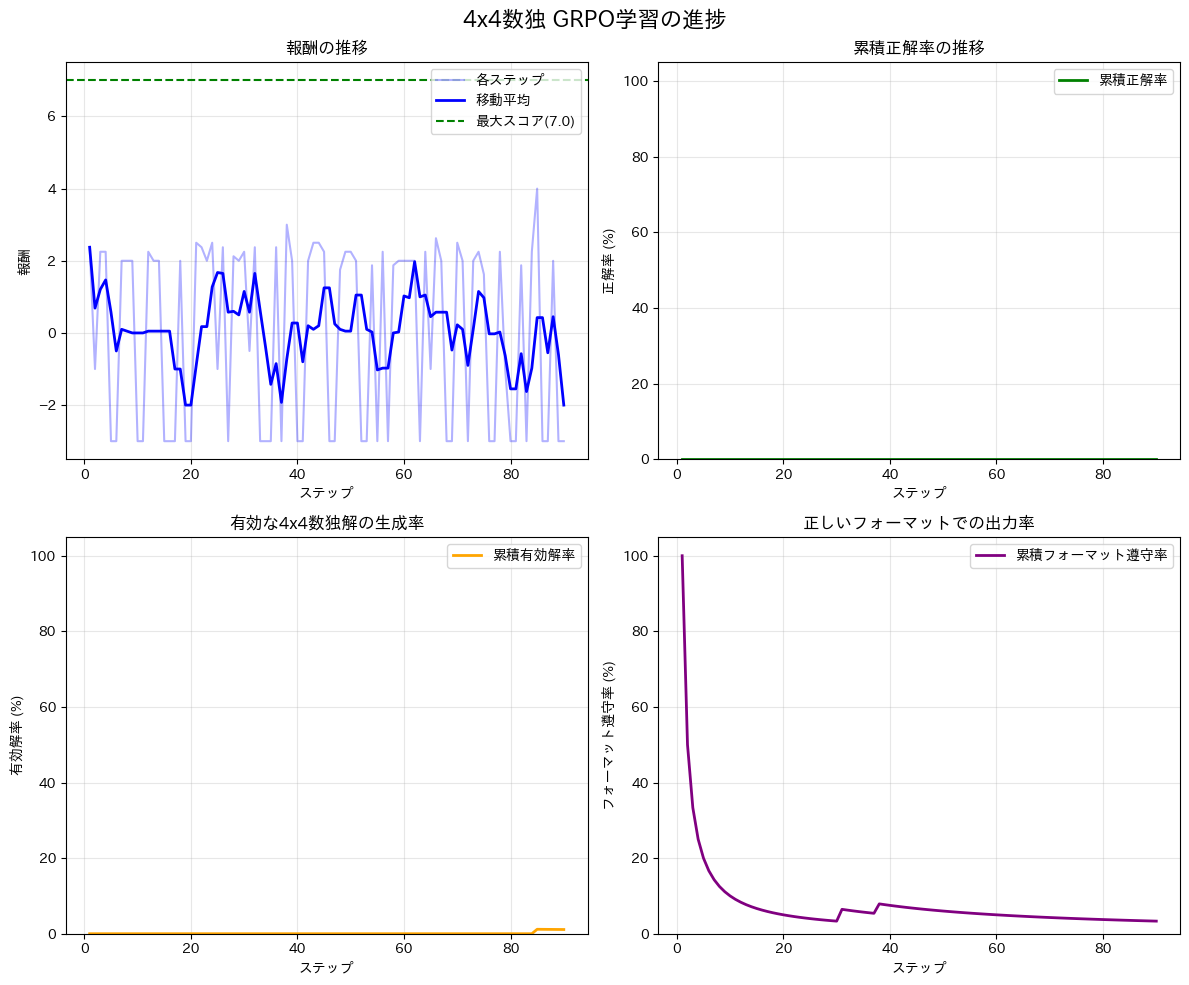

Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / beginner_friendly_reward / mean,rewards / beginner_friendly_reward / std
1,0.000000,0.687500,2.386485,148.500000,120.000000,177.000000,0.000000,148.500000,120.000000,177.000000,0.001228,0.687500,2.386485
2,0.000000,2.250000,0.000000,172.000000,116.000000,228.000000,0.000000,172.000000,116.000000,228.000000,0.000916,2.250000,0.000000
3,0.000000,-3.000000,0.000000,232.000000,232.000000,232.000000,1.000000,0.000000,0.000000,0.000000,0.000814,-3.000000,0.000000
4,0.000000,2.000000,0.000000,208.000000,184.000000,232.000000,0.500000,184.000000,184.000000,184.000000,0.001461,2.000000,0.000000
5,0.000000,-0.500000,3.535534,231.500000,231.000000,232.000000,0.500000,231.000000,231.000000,231.000000,0.001831,-0.500000,3.535534
6,0.000000,-0.375000,3.712311,232.000000,232.000000,232.000000,1.000000,0.000000,0.000000,0.000000,0.002014,-0.375000,3.712311
7,0.000000,2.000000,0.000000,107.000000,82.000000,132.000000,0.000000,107.000000,82.000000,132.000000,0.008357,2.000000,0.000000
8,0.000000,-3.000000,0.000000,232.000000,232.000000,232.000000,1.000000,0.000000,0.000000,0.000000,0.001450,-3.000000,0.000000
9,0.000000,-0.500000,3.535534,174.500000,117.000000,232.000000,0.500000,117.000000,117.000000,117.000000,0.000951,-0.500000,3.535534
10,0.000000,-3.000000,0.000000,232.000000,232.000000,232.000000,1.000000,0.000000,0.000000,0.000000,0.001405,-3.000000,0.000000


KeyboardInterrupt: 

In [19]:
# GRPOトレーナーを作成
from trl import GRPOTrainer

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[beginner_friendly_reward],  # 初心者向け報酬関数を使用
    args=training_args,
    train_dataset=train_dataset,
)

print("🎲 4x4数独のGRPO学習を開始します...")
print("📊 段階的な報酬システムで学習を進めます")
print("-"*50)

# 学習を開始
trainer.train()

print("\n✅ GRPO学習が完了しました！")

## 9. 学習済みモデルのテスト

In [ ]:
import numpy as np
def test_4x4_sudoku_model(model, tokenizer, test_puzzle=None):
    """学習済みモデルで4x4数独を解く"""

    if test_puzzle is None:
        # デフォルトのテストパズル
        test_puzzle = "1200340000214300"  # 簡単な4x4パズル

    # 問題を作成
    question = f"次の4x4数独パズルを解いてください。0は空白を表します:\n{test_puzzle}"

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt = True,
        tokenize = False,
    )

    print("🧪 学習済みモデルのテスト")
    print("="*50)
    print(f"テストパズル: {test_puzzle}")

    # パズルを表示
    print("\nパズル表示:")
    board = np.array([int(c) for c in test_puzzle]).reshape(4, 4)
    for i in range(4):
        if i == 2:
            print("-------")
        row_str = ""
        for j in range(4):
            if j == 2:
                row_str += "| "
            row_str += str(board[i][j]) if board[i][j] != 0 else "."
            row_str += " "
        print(row_str.strip())

    print(f"\n空白セル数: {test_puzzle.count('0')}")
    print("\n生成中...")

    # モデルで生成
    inputs = tokenizer(text, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    print("\n📝 生成された回答:")
    print(generated_text)

    # 解答を抽出
    extracted = extract_answer(generated_text)
    if extracted:
        print(f"\n🎯 抽出された解答: {extracted}")

        # 解答を表示
        if len(extracted) == 16:
            print("\n解答表示:")
            solution_board = np.array([int(c) for c in extracted]).reshape(4, 4)
            for i in range(4):
                if i == 2:
                    print("-------")
                row_str = ""
                for j in range(4):
                    if j == 2:
                        row_str += "| "
                    row_str += str(solution_board[i][j])
                    row_str += " "
                print(row_str.strip())

            # 妥当性チェック
            if is_valid_4x4_sudoku(extracted):
                print("\n✅ 有効な4x4数独解です！")
            else:
                print("\n❌ 無効な解です")
    else:
        print("\n❌ 解答を抽出できませんでした")

    return generated_text

# テスト実行
print("📝 簡単な4x4数独でテスト:")
test_output1 = test_4x4_sudoku_model(model, tokenizer)

print("\n\n📝 別のパズルでテスト:")
test_output2 = test_4x4_sudoku_model(model, tokenizer, "0213000021340000")

## 10. 学習のまとめと次のステップ

In [ ]:
# 最終的な学習統計を表示
print("📊 最終学習統計:")
print("="*50)

if len(reward_history) > 0:
    print(f"総ステップ数: {len(reward_history)}")
    print(f"平均報酬: {np.mean(reward_history):.2f} / 8.0")
    print(f"最高報酬: {max(reward_history):.2f}")
    print(f"最終10ステップ平均: {np.mean(reward_history[-10:]):.2f}")

    total_correct = sum(accuracy_history)
    print(f"\n正解率: {total_correct}/{len(accuracy_history)} ({total_correct/len(accuracy_history)*100:.1f}%)")

    total_valid = sum(valid_solution_history)
    print(f"有効解率: {total_valid}/{len(valid_solution_history)} ({total_valid/len(valid_solution_history)*100:.1f}%)")

    total_format_ok = sum(format_compliance_history)
    print(f"フォーマット遵守率: {total_format_ok}/{len(format_compliance_history)} ({total_format_ok/len(format_compliance_history)*100:.1f}%)")

# モデルの保存
trainer.save_model("grpo_sudoku_4x4_model")
tokenizer.save_pretrained("grpo_sudoku_4x4_model")

print("\n✅ モデルを保存しました: grpo_sudoku_4x4_model/")

# 最終的なグラフを保存
if len(reward_history) > 0:
    plt.savefig('4x4_sudoku_training_final.png', dpi=150, bbox_inches='tight')
    print("📈 学習グラフを保存しました: 4x4_sudoku_training_final.png")

# 最終統計をログに保存
final_stats = {
    'type': 'final_statistics',
    'timestamp': datetime.now().isoformat(),
    'total_steps': len(reward_history),
    'statistics': {
        'avg_reward': float(np.mean(reward_history)) if reward_history else 0,
        'max_reward': float(max(reward_history)) if reward_history else 0,
        'min_reward': float(min(reward_history)) if reward_history else 0,
        'final_10_steps_avg': float(np.mean(reward_history[-10:])) if len(reward_history) >= 10 else float(np.mean(reward_history)) if reward_history else 0,
        'total_correct': int(sum(accuracy_history)),
        'accuracy_rate': float(sum(accuracy_history) / len(accuracy_history)) if accuracy_history else 0,
        'total_valid': int(sum(valid_solution_history)),
        'valid_rate': float(sum(valid_solution_history) / len(valid_solution_history)) if valid_solution_history else 0,
        'total_format_ok': int(sum(format_compliance_history)),
        'format_compliance_rate': float(sum(format_compliance_history) / len(format_compliance_history)) if format_compliance_history else 0
    }
}

with open(log_filename, 'a', encoding='utf-8') as f:
    json.dump(final_stats, f, ensure_ascii=False)
    f.write('\n')

print(f"\n💾 最終統計をログに保存しました: {log_filename}")

print("\n📊 学習のまとめ:")
print("="*50)
print("1. 4x4数独という小さな問題で強化学習の基本を学びました")
print("2. 段階的な報酬システムでモデルの改善を促しました")
print("3. フォーマット学習（SFT）→ 強化学習（GRPO）の流れを体験しました")
print("4. リアルタイムでグラフ表示により学習進捗を可視化しました")
print("5. 各ステップの詳細ログを保存し、後から分析可能にしました")

print("\n🎯 次のステップ:")
print("- より多くのデータで学習を続ける")
print("- 難易度を上げた問題に挑戦する")
print("- 9x9の本格的な数独に進む")
print("- 報酬関数をカスタマイズして実験する")
print("- ログデータを分析して学習過程を詳しく調査する")

print("\n💡 学習のヒント:")
print("- 報酬関数を調整することで、モデルの学習方針を変えられます")
print("- データ量とステップ数を増やすと、より高い精度が期待できます")
print("- 温度パラメータを調整すると、生成の多様性が変わります")
print("- ログファイルを分析することで、どこで失敗しているか詳細に把握できます")

## 11. ログ分析ツール

In [ ]:
def analyze_training_logs(log_file_path):
    """学習ログを分析して統計情報を表示"""

    # 詳細ログを読み込み
    logs = []
    with open(log_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                logs.append(json.loads(line.strip()))
            except:
                pass

    if not logs:
        print("ログが見つかりません")
        return

    print(f"📊 ログ分析結果 ({len(logs)}件)")
    print("="*60)

    # 基本統計
    rewards = [log['reward'] for log in logs if 'reward' in log]
    correct_count = sum(1 for log in logs if log.get('is_correct', False))
    valid_count = sum(1 for log in logs if log.get('is_valid_sudoku', False))

    print(f"\n基本統計:")
    print(f"  総ステップ数: {len(logs)}")
    print(f"  平均報酬: {np.mean(rewards):.2f}")
    print(f"  最高/最低報酬: {max(rewards):.2f} / {min(rewards):.2f}")
    print(f"  正解数: {correct_count} ({correct_count/len(logs)*100:.1f}%)")
    print(f"  有効解数: {valid_count} ({valid_count/len(logs)*100:.1f}%)")

    # フォーマット遵守率
    format_ok = sum(1 for log in logs if log.get('has_reasoning', False) and log.get('has_answer', False))
    print(f"  フォーマット遵守: {format_ok} ({format_ok/len(logs)*100:.1f}%)")

    # エラー分析
    print(f"\nエラー分析:")
    no_extract = sum(1 for log in logs if log.get('extracted_answer') is None)
    print(f"  抽出失敗: {no_extract} ({no_extract/len(logs)*100:.1f}%)")

    # 部分一致の分析
    partial_matches = []
    for log in logs:
        if log.get('matches') is not None and not log.get('is_correct', False):
            partial_matches.append(log['matches'])

    if partial_matches:
        print(f"  部分一致平均: {np.mean(partial_matches):.1f}/16 ({np.mean(partial_matches)/16*100:.1f}%)")

    # 最も失敗した問題
    puzzle_errors = {}
    for log in logs:
        if not log.get('is_correct', False) and log.get('puzzle'):
            puzzle = log['puzzle']
            if puzzle not in puzzle_errors:
                puzzle_errors[puzzle] = 0
            puzzle_errors[puzzle] += 1

    if puzzle_errors:
        print(f"\n最も失敗した問題:")
        sorted_errors = sorted(puzzle_errors.items(), key=lambda x: x[1], reverse=True)[:3]
        for puzzle, count in sorted_errors:
            print(f"  {puzzle}: {count}回失敗")

    # 時系列分析（最初と最後の10ステップ）
    if len(logs) >= 20:
        first_10_rewards = [log['reward'] for log in logs[:10] if 'reward' in log]
        last_10_rewards = [log['reward'] for log in logs[-10:] if 'reward' in log]

        print(f"\n学習の進捗:")
        print(f"  最初の10ステップ平均: {np.mean(first_10_rewards):.2f}")
        print(f"  最後の10ステップ平均: {np.mean(last_10_rewards):.2f}")
        print(f"  改善度: {np.mean(last_10_rewards) - np.mean(first_10_rewards):+.2f}")

    return logs

# 学習ログの分析を実行
if 'detailed_log_filename' in globals() and detailed_log_filename.exists():
    print(f"\n📋 詳細ログの分析:")
    analyze_training_logs(detailed_log_filename)
else:
    print("\n⚠️ まだ学習が実行されていません。学習後にこのセルを再実行してください。")